In [ ]:
!pip install qiskit==0.37.0

In [ ]:
!pip install pylatexenc

K-th Chebyshev polynomial of First kind

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, execute, Aer
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_circuit_layout, circuit_drawer
import numpy as np

def chebyshev_polynomial(k, x):
    if k == 0:
        return 1
    elif k == 1:
        return x
    else:
        T_k_minus_2 = 1 #T_0
        T_k_minus_1 = x #T_1
        for _ in range(2, k + 1):
            T_k = 2 * x * T_k_minus_1 - T_k_minus_2
            T_k_minus_2, T_k_minus_1 = T_k_minus_1, T_k
        return T_k

Function to compute placeholder coefficient c_k_l using FFT/ DCT to define multivariate chebyshev basis function for approximation

In [ ]:
import numpy as np
from scipy.fft import dct

def chebyshev_coeff_2d(f, nx, ny, dx, dy):
    """
    f: target function to approximate
    nx, ny: number of grid points in x and y dimensions
    dx, dy: degree of Chebyshev polynomial in x and y dimensions
    """
    x = np.cos(np.pi * np.arange(nx) / (nx - 1))
    y = np.cos(np.pi * np.arange(ny) / (ny - 1))

    F = np.zeros((nx, ny))
    for i in range(nx):
        for j in range(ny):
            F[i, j] = f(x[i], y[j])

    c_k_l = dct(dct(F.T, type=2, norm='ortho').T, type=2, norm='ortho')

    c_k_l = c_k_l[:dx+1, :dy+1]

    return c_k_l

def target_function(x, y):
    # Example: Bivariate Gaussian function
    return np.exp(-5 * (x**2 + y**2))

# Parameters
nx, ny = 10, 10
dx, dy = 2, 2

coefficients = chebyshev_coeff_2d(target_function, nx, ny, dx, dy)
print("Chebyshev coefficients (c_k_l):")
print(coefficients)


Chebyshev coefficients (c_k_l):
[[ 5.93955630e-01 -9.62796750e-17 -6.70599825e-01]
 [-1.12125562e-16  1.37538884e-18  1.31239652e-16]
 [-6.70599825e-01  1.10629566e-16  7.57134208e-01]]


Multivariate chebyshev basis function in case of 2D with computed coefficient

In [ ]:
from qiskit.circuit.library import RZGate

def chebyshev_polynomial(qc, qubit, k):
    if k == 0:
        return
    elif k == 1:
        qc.h(qubit)
    else:
        # Apply a sequence of RZ gates to approximate higher-degree Chebyshev polynomials
        theta = np.arccos(1 / (2 ** k))
        qc.rz(2 * theta, qubit)

def multivariate_chebyshev(num_qubits_x, num_qubits_y, dx, dy):
    """
    Constructs a quantum circuit that prepares a multivariate Chebyshev series state for the
    specified degrees in x and y dimensions.
    """
    qr_x =  QuantumRegister(num_qubits_x, name='x')
    qr_y =  QuantumRegister(num_qubits_y, name='y')
    qc   =  QuantumCircuit(qr_x, qr_y)

    for k in range(dx + 1):
      for l in range(dy + 1):
        for i in range(num_qubits_x):
          chebyshev_polynomial(qc, qr_x[i], k)
        for j in range(num_qubits_y):
          chebyshev_polynomial(qc, qr_y[j], l)

        c_kl = coefficients[k, l]
        qc.rz(2 * np.arccos(c_kl), qr_x[0])

    return qc

dx, dy = 2, 2
num_qubits_x, num_qubits_y = 3, 3
qc = multivariate_chebyshev(num_qubits_x, num_qubits_y, dx, dy,)
qc.draw(output='text')


┌────────────┐  ┌───────┐   ┌────────────┐    ┌───┐       ┌───────┐   »
x_0: ┤ Rz(1.8697) ├──┤ Rz(π) ├───┤ Rz(4.6116) ├────┤ H ├───────┤ Rz(π) ├───»
     └───┬───┬────┘  └─┬───┬─┘   └───┬───┬────┘┌───┴───┴────┐┌─┴───────┴──┐»
x_1: ────┤ H ├─────────┤ H ├─────────┤ H ├─────┤ Rz(2.6362) ├┤ Rz(2.6362) ├»
         ├───┤         ├───┤         ├───┤     ├────────────┤├────────────┤»
x_2: ────┤ H ├─────────┤ H ├─────────┤ H ├─────┤ Rz(2.6362) ├┤ Rz(2.6362) ├»
         ├───┤     ┌───┴───┴────┐    ├───┤     ├────────────┤└───┬───┬────┘»
y_0: ────┤ H ├─────┤ Rz(2.6362) ├────┤ H ├─────┤ Rz(2.6362) ├────┤ H ├─────»
         ├───┤     ├────────────┤    ├───┤     ├────────────┤    ├───┤     »
y_1: ────┤ H ├─────┤ Rz(2.6362) ├────┤ H ├─────┤ Rz(2.6362) ├────┤ H ├─────»
         ├───┤     ├────────────┤    ├───┤     ├────────────┤    ├───┤     »
y_2: ────┤ H ├─────┤ Rz(2.6362) ├────┤ H ├─────┤ Rz(2.6362) ├────┤ H ├─────»
         └───┘     └────────────┘    └───┘     └────────────┘    └───┘     »
«         ┌───┐     ┌───────┐┌───┐┌───────┐┌────────────┐┌────────────┐»
«x_0: ────┤ H ├─────┤ Rz(π) ├┤ H ├┤ Rz(π) ├┤ Rz(2.6362) ├┤ Rz(4.6116) ├»
«     ┌───┴───┴────┐└───────┘└───┘└───────┘└────────────┘└────────────┘»
«x_1: ┤ Rz(2.6362) ├───────────────────────────────────────────────────»
«     ├────────────┤                                                   »
«x_2: ┤ Rz(2.6362) ├───────────────────────────────────────────────────»
«     ├────────────┤                                                   »
«y_0: ┤ Rz(2.6362) ├───────────────────────────────────────────────────»
«     ├────────────┤                                                   »
«y_1: ┤ Rz(2.6362) ├───────────────────────────────────────────────────»
«     ├────────────┤                                                   »
«y_2: ┤ Rz(2.6362) ├───────────────────────────────────────────────────»
«     └────────────┘                                                   »
«     ┌────────────┐┌───────┐┌────────────┐┌────────────┐
«x_0: ┤ Rz(2.6362) ├┤ Rz(π) ├┤ Rz(2.6362) ├┤ Rz(1.4238) ├
«     └────────────┘└───────┘└────────────┘└────────────┘
«x_1: ───────────────────────────────────────────────────
«                                                        
«x_2: ───────────────────────────────────────────────────
«                                                        
«y_0: ───────────────────────────────────────────────────
«                                                        
«y_1: ───────────────────────────────────────────────────
«                                                        
«y_2: ───────────────────────────────────────────────────
«

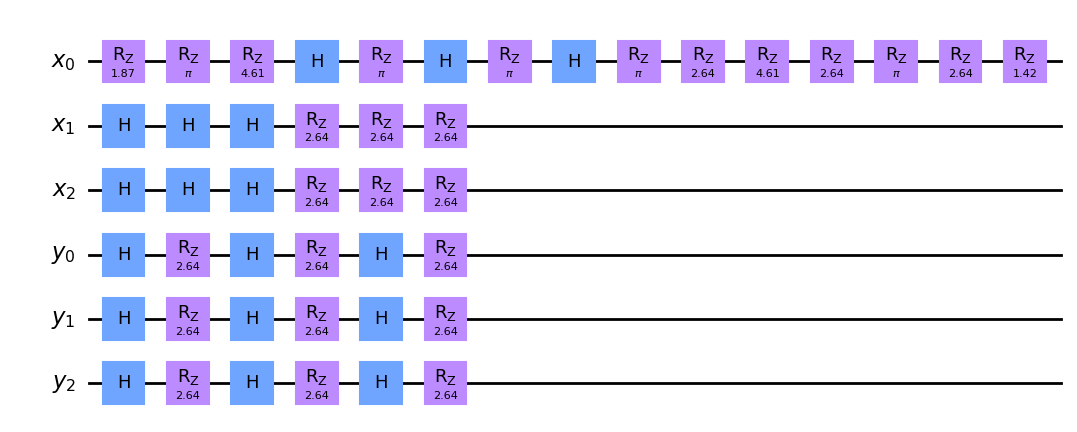

In [ ]:
qc.draw(output = 'mpl')

Discretization and fourier grid preparation

In [ ]:
def fourier_grid(num_qubits):
   grid_points = np.array([k / (2**num_qubits - 1) for k in range(2**num_qubits)])
   hf_matrix = np.diag(grid_points)
   return hf_matrix

num_qubits = 3
hf_grid = fourier_grid(num_qubits)

print("Fourier Grid (HF):")
print(hf_grid)

Fourier Grid (HF):
[[0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.14285714 0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.28571429 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.42857143 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.57142857 0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.71428571
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.85714286 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.        ]]


Discretization and chebyshev grid preparation

In [ ]:
def chebyshev_grid(num_qubits):
  hf_matrix = fourier_grid(num_qubits)
  identity_matrix = np.identity(2**num_qubits)
  hc_matrix = 2 * hf_matrix - identity_matrix
  return hc_matrix

num_qubits = 3
hc_grid = chebyshev_grid(num_qubits)

print("Chebyshev Grid (HC):")
print(hc_grid)

Chebyshev Grid (HC):
[[-1.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -0.71428571  0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.         -0.42857143  0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.         -0.14285714  0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.14285714  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.42857143
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.71428571  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          1.        ]]


Grid for multivariate chebyshev basis function

In [ ]:
# 2d multivariate grid preparation
def multivariate_grid(grid_function, dimensions, num_qubits):
    grid = grid_function(num_qubits)
    multivariate_grid = grid
    for _ in range(1, dimensions):
        multivariate_grid = np.kron(multivariate_grid, grid)
    return multivariate_grid

dimensions = 2
multivariate_hc_grid = multivariate_grid(chebyshev_grid, dimensions, num_qubits)

print("\nMultivariate Chebyshev Grid:")
print(multivariate_hc_grid)


Multivariate Chebyshev Grid:
[[ 1.         -0.         -0.         ...  0.          0.
   0.        ]
 [-0.          0.71428571 -0.         ...  0.          0.
   0.        ]
 [-0.         -0.          0.42857143 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.42857143  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.71428571
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


Phase and magnitude derivation for computing k unitary operator

In [ ]:
from qiskit import ClassicalRegister
lambdas = coefficients.flatten()
gamma_k_l = np.angle(lambdas)

def U_k_chebyshev(k, num_qubits_x, num_qubits_y):
    qr_x = QuantumRegister(num_qubits_x, name='x')
    qr_y = QuantumRegister(num_qubits_y, name='y')
    qc   = QuantumCircuit(qr_x, qr_y)

    for i in range(num_qubits_x):
        chebyshev_polynomial(qc, qr_x[i], k)
    for j in range(num_qubits_y):
        chebyshev_polynomial(qc, qr_y[j], k)
    return qc.to_gate()

def operator_A(lambdas, num_ancillas, num_qubits):
  anc = QuantumRegister(num_ancillas, name='anc')
  reg = QuantumRegister(num_qubits, name='reg')
  qc   = QuantumCircuit(anc, reg)

  lambda_total = np.sum(np.abs(lambdas))

  for i, lambda_k in enumerate(lambdas[:num_ancillas]):
    theta = 2 * np.arcsin(np.sqrt(np.abs(lambda_k) / lambda_total))
    qc.ry(theta, anc[i])
  return qc

def operator_B(U_list, num_ancillas, num_qubits):
  anc = QuantumRegister(num_ancillas, name='anc')
  reg = QuantumRegister(num_qubits, name='reg')
  qc = QuantumCircuit(anc, reg)

  for i, U_k in enumerate(U_list[:num_ancillas]):
    qc.append(U_k.control(1), [anc[i]] + reg[:])
  return qc

def operator_C(phase_list, num_ancillas, num_qubits):
  anc = QuantumRegister(num_ancillas, name='anc')
  reg = QuantumRegister(num_qubits, name='reg')
  qc = QuantumCircuit(anc, reg)

  for i, gamma_k in enumerate(phase_list[:num_ancillas]):
    qc.rz(gamma_k, anc[i])
  return qc

def full_circuit_A_C_B_A_dagger(lambdas, U_list, phase_list, num_ancillas, num_qubits):
    anc = QuantumRegister(num_ancillas, 'anc')
    reg = QuantumRegister(num_qubits, 'reg')
    cr = ClassicalRegister(num_ancillas + num_qubits)
    qc = QuantumCircuit(anc, reg, cr)

    A = operator_A(lambdas, num_ancillas, num_qubits)
    B = operator_B(U_list, num_ancillas, num_qubits)
    C = operator_C(phase_list, num_ancillas, num_qubits)

    qc.append(A.inverse(), anc[:] + reg[:])  # Apply A†
    qc.append(C, anc[:] + reg[:])            # Apply C
    qc.append(B, anc[:] + reg[:])            # Apply B
    qc.append(A, anc[:] + reg[:])            # Apply A

    qc.measure(anc[:] + reg[:], cr[:])

    return qc

num_ancillas = 2
num_qubits_x = 3
num_qubits_y = 3
num_qubits = num_qubits_x + num_qubits_y

K = len(lambdas)
U_list = [U_k_chebyshev(k, num_qubits_x, num_qubits_y) for k in range(K)]

full_circuit = full_circuit_A_C_B_A_dagger(lambdas, U_list, gamma_k_l, num_ancillas, num_qubits)
print(full_circuit.draw())


       ┌───────────────────┐┌────────────────┐┌────────────────┐»
anc_0: ┤0                  ├┤0               ├┤0               ├»
       │                   ││                ││                │»
anc_1: ┤1                  ├┤1               ├┤1               ├»
       │                   ││                ││                │»
reg_0: ┤2                  ├┤2               ├┤2               ├»
       │                   ││                ││                │»
reg_1: ┤3                  ├┤3               ├┤3               ├»
       │  circuit-13734_dg ││  circuit-13762 ││  circuit-13735 │»
reg_2: ┤4                  ├┤4               ├┤4               ├»
       │                   ││                ││                │»
reg_3: ┤5                  ├┤5               ├┤5               ├»
       │                   ││                ││                │»
reg_4: ┤6                  ├┤6               ├┤6               ├»
       │                   ││                ││                │»
reg_5: ┤7 

In [ ]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
import numpy as np

lambdas = coefficients.flatten()
gamma_k_l = np.angle(lambdas)

def U_k_chebyshev(k, num_qubits_x, num_qubits_y):
    qr_x = QuantumRegister(num_qubits_x, name='x')
    qr_y = QuantumRegister(num_qubits_y, name='y')
    qc = QuantumCircuit(qr_x, qr_y)

    for i in range(num_qubits_x):
        chebyshev_polynomial(qc, qr_x[i], k)
    for j in range(num_qubits_y):
        chebyshev_polynomial(qc, qr_y[j], k)

    return qc.to_gate(label=f"U_k({k})")

def operator_A(lambdas, num_ancillas):
    anc = QuantumRegister(num_ancillas, name='anc')
    qc = QuantumCircuit(anc)

    lambda_total = np.sum(np.abs(lambdas))

    for i, lambda_k in enumerate(lambdas[:num_ancillas]):
        theta = 2 * np.arcsin(np.sqrt(np.abs(lambda_k) / lambda_total))
        qc.ry(theta, anc[i])
    return qc

def operator_B_refined(U, num_ancillas, num_qubits):
    anc = QuantumRegister(num_ancillas, name='anc')
    reg = QuantumRegister(num_qubits, name='reg')
    qc = QuantumCircuit(anc, reg)

    for i in range(num_ancillas):
        qc.append(U.power(2**i).control(), [anc[i]] + list(range(num_ancillas, num_ancillas + num_qubits)))

    return qc

def operator_C(phase_list, num_ancillas):
    anc = QuantumRegister(num_ancillas, name='anc')
    qc = QuantumCircuit(anc)

    for i, gamma_k in enumerate(phase_list[:num_ancillas]):
        qc.rz(gamma_k, anc[i])
    return qc

def full_circuit_A_C_B_A_dagger(lambdas, U, phase_list, num_ancillas, num_qubits):
    anc = QuantumRegister(num_ancillas, 'anc')
    reg = QuantumRegister(num_qubits, 'reg')
    cr = ClassicalRegister(num_ancillas + num_qubits)
    qc = QuantumCircuit(anc, reg, cr)

    A = operator_A(lambdas, num_ancillas)
    B = operator_B_refined(U, num_ancillas, num_qubits)
    C = operator_C(phase_list, num_ancillas)


    qc.append(A.inverse(), anc[:])

    qc.append(C, anc[:])

    qc.append(B, anc[:] + reg[:])

    qc.append(A, anc[:])

    qc.measure(anc[:] + reg[:], cr[:])

    return qc

num_ancillas = 2
num_qubits_x = 3
num_qubits_y = 3
num_qubits = num_qubits_x + num_qubits_y

U = U_k_chebyshev(1, num_qubits_x, num_qubits_y)

full_circuit = full_circuit_A_C_B_A_dagger(lambdas, U, gamma_k_l, num_ancillas, num_qubits)

# Print the quantum circuit
print(full_circuit.draw())

       ┌───────────────────┐┌────────────────┐┌────────────────┐»
anc_0: ┤0                  ├┤0               ├┤0               ├»
       │  circuit-13776_dg ││  circuit-26640 ││                │»
anc_1: ┤1                  ├┤1               ├┤1               ├»
       └───────────────────┘└────────────────┘│                │»
reg_0: ───────────────────────────────────────┤2               ├»
                                              │                │»
reg_1: ───────────────────────────────────────┤3               ├»
                                              │  circuit-13777 │»
reg_2: ───────────────────────────────────────┤4               ├»
                                              │                │»
reg_3: ───────────────────────────────────────┤5               ├»
                                              │                │»
reg_4: ───────────────────────────────────────┤6               ├»
                                              │                │»
reg_5: ───

Block Encoding of 2D Chebyshev basis function

In [ ]:
from qiskit.circuit.library import XGate, ZGate, IGate
n_x = 2
n_y = 2
ancilla_qubits = 2
k = 3

qc = QuantumCircuit(n_x + n_y + ancilla_qubits)

def apply_xzx(q, j):
  qc.x(j)
  qc.z(j)
  qc.x(j)

def construct_HC(qc, n_x, n_y):
  for j in range(n_x):
    factor_x = 2**j / (2**n_x - 1)
    apply_xzx(qc, j)

  for j in range(n_y):
    factor_y = 2**j / (2**n_y - 1)
    apply_xzx(qc, j + n_x)

def apply_A_V(qc, n_x, n_y, ancilla_qubits):
  for j in range(n_x):
    factor_x = np.sqrt(2**j / (2**n_x - 1))
    control_qubit = ancilla_qubits - 1 - j
    qc.cry(2 * factor_x, control_qubit, j)

  for j in range(n_y):
    factor_y = np.sqrt(2**j / (2**n_y - 1))
    control_qubit = ancilla_qubits - 1 - j
    qc.cry(2 * factor_y, control_qubit, j + n_x)

def apply_B_V(qc, n_x, n_y, ancilla_qubits):
  for j in range(n_x):
    control_qubit = ancilla_qubits - 1 - j
    qc.cx(control_qubit, j)
    qc.cz(control_qubit, j)
    qc.cx(control_qubit, j)

  for j in range(n_y):
    control_qubit = ancilla_qubits - 1 - j
    qc.cx(control_qubit, j + n_x)
    qc.cz(control_qubit, j + n_x)
    qc.cx(control_qubit, j + n_x)

def apply_A_V_dagger(qc, n_x, n_y, ancilla_qubits):
  for j in range(n_x):
    factor_x = np.sqrt(2**j / (2**n_x - 1))
    control_qubit = ancilla_qubits - 1 - j
    qc.cry(-2 * factor_x, control_qubit, j)

  for j in range(n_y):
    factor_y = np.sqrt(2**j / (2**n_y - 1))
    control_qubit = ancilla_qubits - 1 - j
    qc.cry(-2 * factor_y, control_qubit, j + n_x)

#Recursive calculation of 2D Chebyshev polynomial T_k(H_C)
def compute_Tk_HC(qc, n_x, n_y, ancilla_qubits, k):
  construct_HC(qc, n_x, n_y)

  for i in range(2, k + 1):
     qc.barrier()
     construct_HC(qc, n_x, n_y)
     construct_HC(qc, n_x, n_y)
     qc.x(range(n_x + n_y))

def apply_V(qc, n_x, n_y, ancilla_qubits):
    apply_A_V(qc, n_x, n_y, ancilla_qubits)
    apply_B_V(qc, n_x, n_y, ancilla_qubits)
    apply_A_V_dagger(qc, n_x, n_y, ancilla_qubits)

apply_V(qc, n_x, n_y, ancilla_qubits)
compute_Tk_HC(qc, n_x, n_y, ancilla_qubits, k)
qc.draw(output='text')

┌────────────┐                                        ┌───┐   ┌───┐     »
q_0: ┤ Ry(1.1547) ├──────■──────────────────────────■──────┤ X ├─■─┤ X ├──■──»
     └─────┬──────┘┌─────┴─────┐                    │      └─┬─┘ │ └─┬─┘┌─┴─┐»
q_1: ──────■───────┤ Ry(1.633) ├──────■─────────────┼────────■───■───■──┤ X ├»
                   └───────────┘┌─────┴──────┐      │                   └───┘»
q_2: ───────────────────────────┤ Ry(1.1547) ├──────┼────────────────────────»
                                └────────────┘┌─────┴─────┐                  »
q_3: ─────────────────────────────────────────┤ Ry(1.633) ├──────────────────»
                                              └───────────┘                  »
q_4: ────────────────────────────────────────────────────────────────────────»
                                                                             »
q_5: ────────────────────────────────────────────────────────────────────────»
                                                                             »
«                                       ┌─────────────┐              »
«q_0: ─■───■─────────■──────■────────■──┤ Ry(-1.1547) ├──────■───────»
«      │ ┌─┴─┐       │      │        │  └──────┬──────┘┌─────┴──────┐»
«q_1: ─■─┤ X ├──■────┼───■──┼───■────┼─────────■───────┤ Ry(-1.633) ├»
«        └───┘┌─┴─┐  │   │  │ ┌─┴─┐  │                 └────────────┘»
«q_2: ────────┤ X ├──┼───■──┼─┤ X ├──┼───────────────────────────────»
«             └───┘┌─┴─┐    │ └───┘┌─┴─┐                             »
«q_3: ─────────────┤ X ├────■──────┤ X ├─────────────────────────────»
«                  └───┘           └───┘                             »
«q_4: ───────────────────────────────────────────────────────────────»
«                                                                    »
«q_5: ───────────────────────────────────────────────────────────────»
«                                                                    »
«                                  ┌───┐┌───┐┌───┐ ░ ┌───┐┌───┐┌───┐┌───┐┌───┐»
«q_0: ─────────────────────■───────┤ X ├┤ Z ├┤ X ├─░─┤ X ├┤ Z ├┤ X ├┤ X ├┤ Z ├»
«                          │       ├───┤├───┤├───┤ ░ ├───┤├───┤├───┤├───┤├───┤»
«q_1: ───────■─────────────┼───────┤ X ├┤ Z ├┤ X ├─░─┤ X ├┤ Z ├┤ X ├┤ X ├┤ Z ├»
«     ┌──────┴──────┐      │       ├───┤├───┤├───┤ ░ ├───┤├───┤├───┤├───┤├───┤»
«q_2: ┤ Ry(-1.1547) ├──────┼───────┤ X ├┤ Z ├┤ X ├─░─┤ X ├┤ Z ├┤ X ├┤ X ├┤ Z ├»
«     └─────────────┘┌─────┴──────┐├───┤├───┤├───┤ ░ ├───┤├───┤├───┤├───┤├───┤»
«q_3: ───────────────┤ Ry(-1.633) ├┤ X ├┤ Z ├┤ X ├─░─┤ X ├┤ Z ├┤ X ├┤ X ├┤ Z ├»
«                    └────────────┘└───┘└───┘└───┘ ░ └───┘└───┘└───┘└───┘└───┘»
«q_4: ─────────────────────────────────────────────░──────────────────────────»
«                                                  ░                          »
«q_5: ─────────────────────────────────────────────░──────────────────────────»
«                                                  ░                          »
«     ┌───┐┌───┐ ░ ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐
«q_0: ┤ X ├┤ X ├─░─┤ X ├┤ Z ├┤ X ├┤ X ├┤ Z ├┤ X ├┤ X ├
«     ├───┤├───┤ ░ ├───┤├───┤├───┤├───┤├───┤├───┤├───┤
«q_1: ┤ X ├┤ X ├─░─┤ X ├┤ Z ├┤ X ├┤ X ├┤ Z ├┤ X ├┤ X ├
«     ├───┤├───┤ ░ ├───┤├───┤├───┤├───┤├───┤├───┤├───┤
«q_2: ┤ X ├┤ X ├─░─┤ X ├┤ Z ├┤ X ├┤ X ├┤ Z ├┤ X ├┤ X ├
«     ├───┤├───┤ ░ ├───┤├───┤├───┤├───┤├───┤├───┤├───┤
«q_3: ┤ X ├┤ X ├─░─┤ X ├┤ Z ├┤ X ├┤ X ├┤ Z ├┤ X ├┤ X ├
«     └───┘└───┘ ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘
«q_4: ───────────░────────────────────────────────────
«                ░                                    
«q_5: ───────────░────────────────────────────────────
«                ░

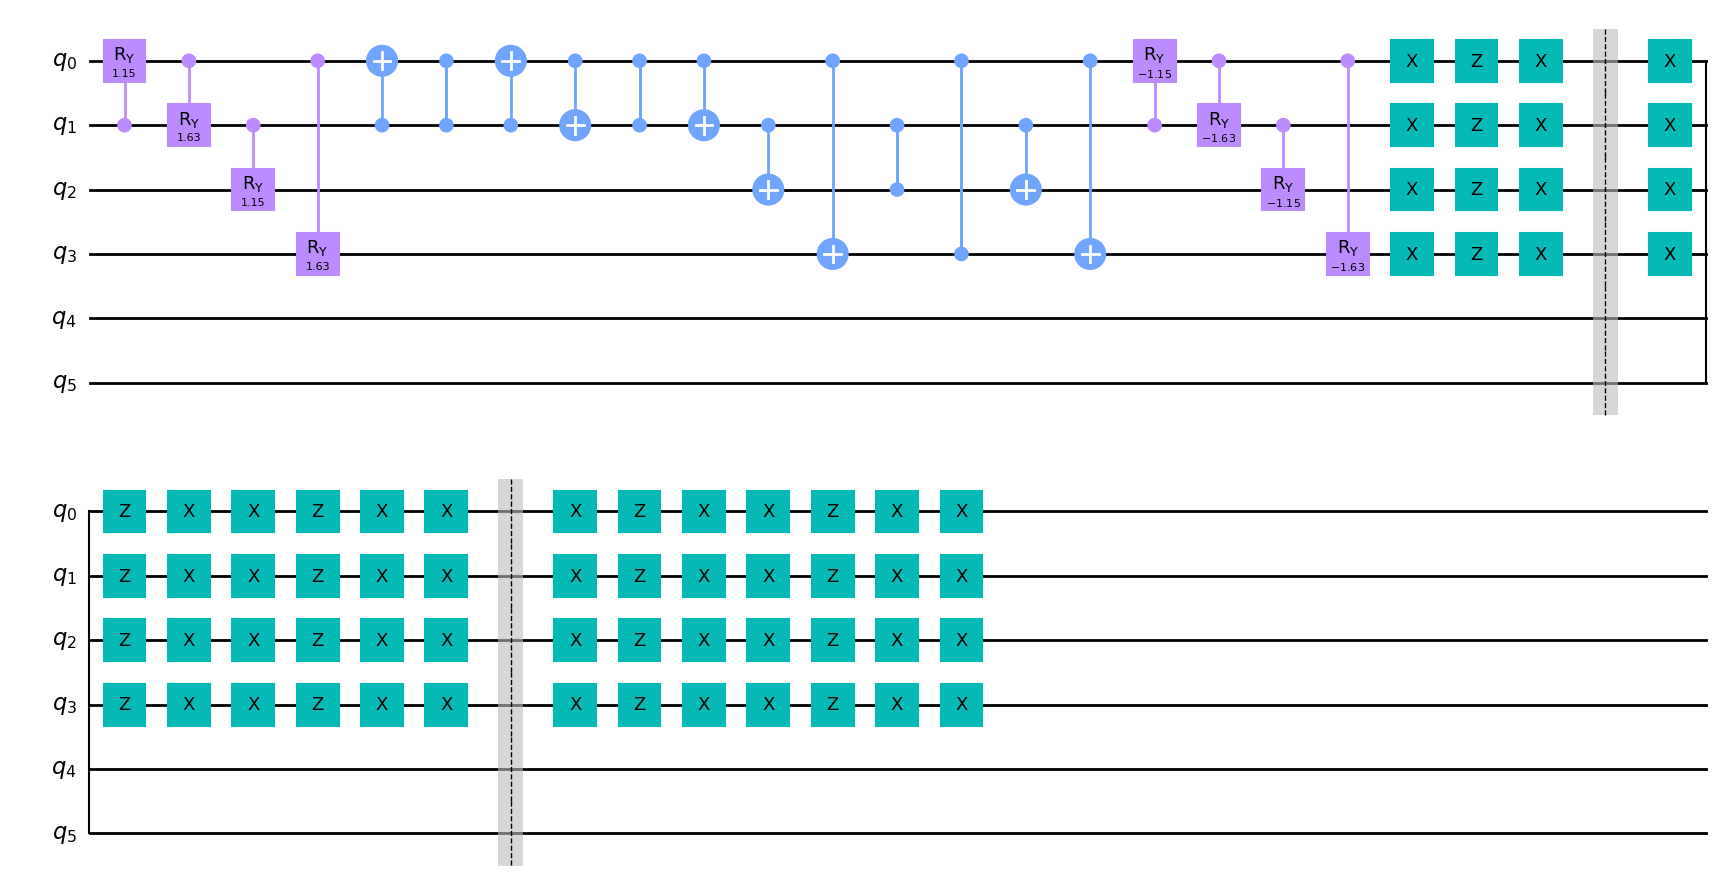

In [ ]:
qc.draw(output='mpl')

In [ ]:
qc.draw(output='mpl')

simulator = Aer.get_backend('statevector_simulator')
result = execute(qc, simulator).result()
statevector = result.get_statevector()

print(statevector)

Statevector([ 1.00000000e+00+2.46519033e-32j,
             -5.20499090e-18-1.22464680e-16j,
             -2.50551713e-17-1.22464680e-16j,
              2.43000608e-18+3.32247692e-33j,
              7.32355784e-20-1.22464680e-16j,
             -3.42471794e-18-4.25880373e-34j,
             -3.75603524e-18+1.47763696e-33j,
              5.42346092e-18+1.86646259e-33j,
             -2.30440895e-17-1.22464680e-16j,
             -5.60483454e-18+2.22106169e-33j,
             -8.58038824e-21+5.57641531e-33j,
              2.56663059e-18+6.24936582e-34j,
             -1.48996898e-32+3.26415342e-33j,
             -3.66356432e-18-9.48053787e-34j,
             -1.94171303e-20-2.53984635e-34j,
              5.78030618e-18+2.30406453e-33j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.000

Implementation of Block Encoding and chebyshev polynomials to approximate higher order transformations

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile, assemble
from qiskit.circuit.library import RZGate
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info.operators import Operator
from scipy.linalg import expm

def chebyshev_polynomial(k, x):
    if k == 0:
        return 1
    elif k == 1:
        return x
    else:
        T_k_minus_2 = 1  # T_0(x)
        T_k_minus_1 = x  # T_1(x)
        for _ in range(2, k + 1):
            T_k = 2 * x * T_k_minus_1 - T_k_minus_2
            T_k_minus_2, T_k_minus_1 = T_k_minus_1, T_k
        return T_k

def chebyshev_u(k, x):
    if k == 0:
        return 1
    elif k == 1:
        return 2 * x
    else:
        U_k_minus_2 = 1
        U_k_minus_1 = 2 * x
        for _ in range(2, k + 1):
            U_k = 2 * x * U_k_minus_1 - U_k_minus_2
            U_k_minus_2, U_k_minus_1 = U_k_minus_1, U_k
        return U_k

def block_encoding_matrix(V):
    """Construct the block encoding matrix U_V."""
    xi = np.linalg.eigvals(V)
    UV_blocks = []

    for x in xi:
        block = np.array([[x, -np.sqrt(1 - x**2)], [np.sqrt(1 - x**2), x]])
        UV_blocks.append(block)

    UV = np.block([[block if i == j else np.zeros_like(block) for j, block in enumerate(UV_blocks)]
                    for i, block in enumerate(UV_blocks)])

    return UV

def qubitization_operator(V):
    """Implement qubitized block-encoding operator as per Equation 21."""
    dim = V.shape[0]
    I_b = np.eye(dim)

    zero_proj = np.zeros((dim, dim))
    zero_proj[0, 0] = 1

    control_operator = 2 * zero_proj - I_b

    V_extended = np.kron(np.eye(2), V)

    qubitized_UV = np.kron(control_operator, np.eye(dim)) @ V_extended

    return qubitized_UV



def apply_chebyshev_polynomials(V, k):
    xi = np.linalg.eigvals(V)
    UV_blocks = []

    for x in xi:
        Tk_xi = chebyshev_polynomial(k, x)
        Uk_minus1_xi = chebyshev_u(k-1, x) if k > 0 else 1

        block = np.array([[Tk_xi, -np.sqrt(1 - x**2) * Uk_minus1_xi],
                          [np.sqrt(1 - x**2) * Uk_minus1_xi, Tk_xi]])
        UV_blocks.append(block)

    UV_k = np.block([[block if i == j else np.zeros_like(block) for j, block in enumerate(UV_blocks)]
                     for i, block in enumerate(UV_blocks)])

    return UV_k

def final_block_encoding(V, k):
    UV_k = apply_chebyshev_polynomials(V, k)
    return UV_k

V = np.array([[0.6, 0.8], [0.8, -0.6]])

UV_qubitized = qubitization_operator(V)
UV_final = final_block_encoding(V, k=3)  # k = 3 for example

print("Qubitized block-encoding U_V:\n", UV_qubitized)
print("Final block-encoding U_V^k (k=3):\n", UV_final)

def build_circuit(U_matrix):
    """Create a quantum circuit to implement the given unitary."""
    num_qubits = int(np.log2(U_matrix.shape[0]))
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)

    U_op = Operator(U_matrix)
    qc.unitary(U_op, qr)

    return qc

qc = build_circuit(UV_final)
simulator = Aer.get_backend('statevector_simulator')
compiled_qc = transpile(qc, simulator)
qobj = assemble(compiled_qc)
result = simulator.run(qobj, shots=1, memory=True).result()

# Output the final statevector
statevector = result.get_statevector(compiled_qc)
print(statevector)

Qubitized block-encoding U_V:
 [[ 0.6  0.8  0.   0. ]
 [ 0.8 -0.6  0.   0. ]
 [ 0.   0.  -0.6 -0.8]
 [ 0.   0.  -0.8  0.6]]
Final block-encoding U_V^k (k=3):
 [[ 1. -0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1. -0.]
 [ 0.  0.  0. -1.]]
Statevector([ 1.+0.j,  0.+0.j, -0.+0.j, -0.+0.j],
            dims=(2, 2))


In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.extensions import UnitaryGate

def chebyshev_polynomial(k, x):
    if k == 0:
        return 1
    elif k == 1:
        return x
    else:
        T_k_minus_1 = x  # T_1(x) = x
        T_k_minus_2 = 1  # T_0(x) = 1
        for _ in range(2, k + 1):
            T_k = 2 * x * T_k_minus_1 - T_k_minus_2
            T_k_minus_2 = T_k_minus_1
            T_k_minus_1 = T_k
        return T_k

def chebyshev_u(k, x):
    if k == 0:
        return 1
    elif k == 1:
        return 2 * x
    else:
        U_k_minus_1 = 2 * x  # U_1(x) = 2 * x
        U_k_minus_2 = 1  # U_0(x) = 1
        for _ in range(2, k + 1):
            U_k = 2 * x * U_k_minus_1 - U_k_minus_2
            U_k_minus_2 = U_k_minus_1
            U_k_minus_1 = U_k
        return U_k

def apply_chebyshev_polynomials(V, k):
    xi = np.linalg.eigvals(V)  # Eigenvalues of matrix V
    UV_blocks = []

    for x in xi:
        T_k_x = chebyshev_polynomial(k, x)  # T_k(x)
        U_k_minus_1_x = chebyshev_u(k - 1, x) if k > 0 else 1  # U_(k-1)(x)

        block = np.array([[T_k_x, -np.sqrt(1 - x**2) * U_k_minus_1_x],
                          [np.sqrt(1 - x**2) * U_k_minus_1_x, T_k_x]])
        UV_blocks.append(block)

    # Construct full block encoding matrix from UV_blocks
    UV_k = np.block([[block if i == j else np.zeros_like(block) for j, block in enumerate(UV_blocks)]
                     for i, block in enumerate(UV_blocks)])

    return UV_k

def operator_B(U_list, num_ancillas, num_qubits):
    anc = QuantumRegister(num_ancillas, name='anc')
    reg = QuantumRegister(num_qubits, name='reg')
    qc = QuantumCircuit(anc, reg)

    for i in range(min(num_ancillas, num_qubits)):
        # Controlled version of U_k, as in Eq. (9)
         U_k_gate = UnitaryGate(U_list[i])
         controlled_U_k = U_k_gate.control(1)

         qc.append(controlled_U_k, [anc[i], reg[i]])

    return qc

def operator_B_refined(U, num_ancillas, num_qubits):
    anc = QuantumRegister(num_ancillas, name='anc')
    reg = QuantumRegister(num_qubits, name='reg')
    qc = QuantumCircuit(anc, reg)

    U_gate = UnitaryGate(U)

    for i in range(num_ancillas):
        # Apply controlled powers of U, as in Eq. (12)
       controlled_U_power = U_gate.power(2**i).control(1)
       qc.append(controlled_U_power, [anc[i]] + list(range(num_ancillas, num_ancillas + num_qubits)))

    return qc

def construct_finite_chebyshev_series(U_list, num_ancillas, num_qubits):
    qc = QuantumCircuit(num_ancillas + num_qubits)

    qc.compose(operator_B(U_list, num_ancillas, num_qubits))


    U = apply_chebyshev_polynomials(U_list[0], len(U_list))
    qc = qc.compose(operator_B_refined(U, num_ancillas, num_qubits))

    return qc

# Example usage:
U_list = [np.eye(2)] * 4
num_ancillas = 3
num_qubits = 2

circuit = construct_finite_chebyshev_series(U_list, num_ancillas, num_qubits)
print(circuit.draw())

                                               
q_0: ──────■───────────────────────────────────
           │                                   
q_1: ──────┼─────────────■─────────────────────
           │             │                     
q_2: ──────┼─────────────┼─────────────■───────
     ┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐
q_3: ┤0           ├┤0           ├┤0           ├
     │  unitary^1 ││  unitary^2 ││  unitary^4 │
q_4: ┤1           ├┤1           ├┤1           ├
     └────────────┘└────────────┘└────────────┘


In [ ]:
def construct_simplified_circuit(num_ancillas, num_main_qubits, U):

    anc = AncillaRegister(num_ancillas, name='anc')
    reg = QuantumRegister(num_main_qubits, name='reg')
    qc = QuantumCircuit(anc, reg)

    for i in range(num_ancillas):
        qc.append(U.control(), [anc[i]] + list(reg))

    for i in range(num_ancillas):
        qc.append(U.power(2).control(), [anc[i]] + list(reg))

    return qc


num_ancillas = 3
num_main_qubits = 2
U = QuantumCircuit(2)


U.cz(0, 1)


simplified_circuit = construct_simplified_circuit(num_ancillas, num_main_qubits, U)

print(simplified_circuit.draw())
qc.draw(output='text')

       ┌──────────────────┐                                        »
anc_0: ┤0                 ├────────────────────────────────────────»
       │                  │┌──────────────────┐                    »
anc_1: ┤                  ├┤0                 ├────────────────────»
       │                  ││                  │┌──────────────────┐»
anc_2: ┤  c_circuit-27190 ├┤                  ├┤0                 ├»
       │                  ││  c_circuit-27190 ││                  │»
reg_0: ┤1                 ├┤1                 ├┤1 c_circuit-27190 ├»
       │                  ││                  ││                  │»
reg_1: ┤2                 ├┤2                 ├┤2                 ├»
       └──────────────────┘└──────────────────┘└──────────────────┘»
«       ┌─────────────────────┐                                              
«anc_0: ┤0                    ├──────────────────────────────────────────────
«       │                     │┌─────────────────────┐                       
«anc_1:

┌──────────┐
q13095_0: ┤0         ├
          │  Unitary │
q13095_1: ┤1         ├
          └──────────┘

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister

def apply_A_V(qc, n_x, n_y, ancilla_qubits):
    for j in range(n_x):
        factor_x = np.sqrt(2**j / (2**n_x - 1))
        control_qubit = ancilla_qubits + j
        qc.cry(2 * factor_x, control_qubit, j)

    for j in range(n_y):
        factor_y = np.sqrt(2**j / (2**n_y - 1))
        control_qubit = ancilla_qubits + j
        qc.cry(2 * factor_y, control_qubit, j + n_x)

def apply_B_V(qc, n_x, n_y, ancilla_qubits):
    for j in range(n_x):
        control_qubit = ancilla_qubits + j
        qc.cx(control_qubit, j)
        qc.cz(control_qubit, j)
        qc.cx(control_qubit, j)

    for j in range(n_y):
        control_qubit = ancilla_qubits + j
        qc.cx(control_qubit, j + n_x)
        qc.cz(control_qubit, j + n_x)
        qc.cx(control_qubit, j + n_x)

def apply_A_V_dagger(qc, n_x, n_y, ancilla_qubits):
    for j in range(n_x):
        factor_x = np.sqrt(2**j / (2**n_x - 1))
        control_qubit = ancilla_qubits + j
        qc.cry(-2 * factor_x, control_qubit, j)

    for j in range(n_y):
        factor_y = np.sqrt(2**j / (2**n_y - 1))
        control_qubit = ancilla_qubits + j
        qc.cry(-2 * factor_y, control_qubit, j + n_x)

def apply_C_V(qc, ancilla_qubits):
    for i in range(ancilla_qubits):
        qc.rz(np.pi / 4, i)

def apply_R(qc, ancilla_qubits):
    """Apply the reflection operator R using X gates."""
    for i in range(ancilla_qubits):
        qc.x(i)
def UV_k_circuit(n_x, n_y, ancilla_qubits):
    """
    Construct the full U_k^V circuit as:
    U_k^V = R A_V^dagger C_V B_V A_V
    """
    anc = AncillaRegister(ancilla_qubits, name='anc')
    reg = QuantumRegister(n_x + n_y, name='reg')
    qc = QuantumCircuit(anc, reg)

    apply_A_V(qc, n_x, n_y, ancilla_qubits)
    qc.barrier()

    apply_B_V(qc, n_x, n_y, ancilla_qubits)
    qc.barrier()

    apply_C_V(qc, ancilla_qubits)
    qc.barrier()

    apply_A_V_dagger(qc, n_x, n_y, ancilla_qubits)
    qc.barrier()

    apply_R(qc, ancilla_qubits)
    qc.barrier()

    return qc

n_x = 2
n_y = 2
ancilla_qubits = 3

UV_k = UV_k_circuit(n_x, n_y, ancilla_qubits)

print(UV_k.draw(output='text'))

       ┌────────────┐                                         ░ ┌───┐        »
anc_0: ┤ Ry(1.1547) ├─────────────────────────────────────────░─┤ X ├──────■─»
       └─────┬──────┘┌───────────┐                            ░ └─┬─┘┌───┐ │ »
anc_1: ──────┼───────┤ Ry(1.633) ├────────────────────────────░───┼──┤ X ├─┼─»
             │       └─────┬─────┘┌────────────┐              ░   │  └─┬─┘ │ »
anc_2: ──────┼─────────────┼──────┤ Ry(1.1547) ├──────────────░───┼────┼───┼─»
             │             │      └─────┬──────┘┌───────────┐ ░   │    │   │ »
reg_0: ──────■─────────────┼────────────■───────┤ Ry(1.633) ├─░───■────┼───■─»
                           │                    └─────┬─────┘ ░        │     »
reg_1: ────────────────────■──────────────────────────■───────░────────■─────»
                                                              ░              »
reg_2: ───────────────────────────────────────────────────────░──────────────»
                                                    

Multivariate State preparation

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister

def create_operator_A_chebyshev(Kx, Ky, normalized_coefficients, n):
    ax = int(np.ceil(np.log2(Kx)))
    ay = int(np.ceil(np.log2(Ky)))
    ancilla_qubits_x = QuantumRegister(ax, 'ancilla_x')
    ancilla_qubits_y = QuantumRegister(ay, 'ancilla_y')
    main_register = QuantumRegister(n, 'main')

    A = QuantumCircuit(ancilla_qubits_x, ancilla_qubits_y, main_register)


    for k in range(Kx):
        for l in range(Ky):
            coefficient_magnitude = np.sqrt(normalized_coefficients[k, l])
            if coefficient_magnitude > 0:
                A.ry(2 * np.arccos(coefficient_magnitude), main_register[0])
                pass

    return A

def create_operator_BX_chebyshev(Kx, n):
    ax = int(np.ceil(np.log2(Kx)))
    ancilla_qubits_x = QuantumRegister(ax, 'ancilla_x')
    main_register = QuantumRegister(n, 'main')

    BX = QuantumCircuit(ancilla_qubits_x, main_register)

    for k in range(Kx):
      for j in range(n):
        theta = (k * np.pi) / (2 ** j)
        BX.cx(ancilla_qubits_x[0], main_register[j])

    return BX

def create_operator_BY_chebyshev(Ky, n):
    ay = int(np.ceil(np.log2(Ky)))
    ancilla_qubits_y = QuantumRegister(ay, 'ancilla_y')
    main_register = QuantumRegister(n, 'main')

    BY = QuantumCircuit(ancilla_qubits_y, main_register)

    for l in range(Ky):
      for j in range(n):
        phi = (l * np.pi) / (2 ** j)
        BY.cx(ancilla_qubits_y[0], main_register[j])


    return BY

def create_operator_C_chebyshev(Kx, Ky, phases, n):
    ax = int(np.ceil(np.log2(Kx)))
    ay = int(np.ceil(np.log2(Ky)))
    ancilla_qubits_x = QuantumRegister(ax, 'ancilla_x')
    ancilla_qubits_y = QuantumRegister(ay, 'ancilla_y')
    main_register = QuantumRegister(n, 'main')

    C = QuantumCircuit(ancilla_qubits_x, ancilla_qubits_y, main_register)

    for k in range(Kx):
        for l in range(Ky):
            phase = phases[k, l]
            if phase != 0:
                C.rz(phase, main_register[0])

    return C

def prepare_2d_state_chebyshev(Kx, Ky, normalized_coefficients, phases, n):
    A = create_operator_A_chebyshev(Kx, Ky, normalized_coefficients, n)
    BX = create_operator_BX_chebyshev(Kx, n)
    BY = create_operator_BY_chebyshev(Ky, n)
    C = create_operator_C_chebyshev(Kx, Ky, phases, n)

    full_circuit = A.inverse().compose(C).compose(BY).compose(BX).compose(A)

    return full_circuit

Kx, Ky = 3, 3
nx, ny = 10, 10
dx, dy = 2, 2

coefficients = chebyshev_coeff_2d(target_function, nx, ny, dx, dy)
magnitudes = np.abs(coefficients)
phases = np.angle(coefficients)
N = np.sum(magnitudes)
normalized_coefficients = magnitudes / N

print("Normalized Chebyshev coefficients:")
print(normalized_coefficients)

circuit = prepare_2d_state_chebyshev(Kx, Ky, normalized_coefficients, phases, n)

print(circuit.draw(output = 'text'))
qc.draw(output='text')

Normalized Chebyshev coefficients:
[[2.20613583e-01 3.57612639e-17 2.49081619e-01]
 [4.16469189e-17 5.10862168e-19 4.87464859e-17]
 [2.49081619e-01 4.10912594e-17 2.81223179e-01]]
                                                                         »
ancilla_x_0: ───────■───────────■────────────────────────────────────────»
                    │           │                                        »
ancilla_x_1: ───────┼───────────┼────────────────────────────────────────»
                  ┌─┴─┐         │                                        »
ancilla_y_0: ─────┤ X ├─────────┼────────────────────────────────────────»
                  └───┘       ┌─┴─┐                                      »
ancilla_y_1: ─────────────────┤ X ├──────────────────────────────────────»
             ┌─────────────┐┌─┴───┴──┐┌─────────────┐┌────────┐┌────────┐»
     main_0: ┤ Ry(-2.0237) ├┤ Ry(-π) ├┤ Ry(-2.0965) ├┤ Ry(-π) ├┤ Ry(-π) ├»
             └─────────────┘└────────┘└─────────────┘└────────┘└──────

┌──────────┐
q13095_0: ┤0         ├
          │  Unitary │
q13095_1: ┤1         ├
          └──────────┘

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.circuit.library import HGate

def prepare_uniform_superposition(circuit, main_register):
    """Apply Hadamard gates to create a uniform superposition over the main register."""
    for qubit in main_register:
        circuit.h(qubit)
    return circuit

def measure_and_post_select(circuit, ancilla_qubits, register_name):
    """Measure ancilla qubits and post-select on the zero state."""
    classical_bits = ClassicalRegister(len(ancilla_qubits), name=register_name)
    circuit.add_register(classical_bits)
    circuit.measure(ancilla_qubits, classical_bits)
    return circuit

def calculate_probability_success(counts, total_shots, zero_state):
    """Calculate the probability of successful outcome based on measurement counts."""
    print(f"counts: {counts}")
    success_count = counts.get(zero_state, 0)
    P_success = success_count / total_shots
    return P_success

def prepare_2d_state_chebyshev_full(Kx, Ky, normalized_coefficients, phases, n, total_shots=1024):
    # Create LCU operators using the Chebyshev coefficients
    A = create_operator_A_chebyshev(Kx, Ky, normalized_coefficients,n)
    BX = create_operator_BX_chebyshev(Kx, n)
    BY = create_operator_BY_chebyshev(Ky, n)
    C = create_operator_C_chebyshev(Kx, Ky, phases, n)

    # Initialize quantum registers
    ax = int(np.ceil(np.log2(Kx)))  # Ancilla qubits for x dimension
    ay = int(np.ceil(np.log2(Ky)))  # Ancilla qubits for y dimension
    ancilla_qubits_x = QuantumRegister(ax, 'ancilla_x')
    ancilla_qubits_y = QuantumRegister(ay, 'ancilla_y')
    main_register = QuantumRegister(n, 'main')

    # Create quantum circuit
    full_circuit = QuantumCircuit(ancilla_qubits_x, ancilla_qubits_y, main_register)

    # Step 1: Prepare uniform superposition over main registers
    prepare_uniform_superposition(full_circuit, main_register)

    # Step 2: Apply the operators A† C BY BX A

    full_circuit.append(A.inverse(), ancilla_qubits_x[:] + ancilla_qubits_y[:] + main_register[:]) # Modified line
    full_circuit.append(C, ancilla_qubits_x[:] + ancilla_qubits_y[:] + main_register[:])           # Modified line
    full_circuit.append(BY, ancilla_qubits_y[:] + main_register[:])                               # Modified line
    full_circuit.append(BX, ancilla_qubits_x[:] + main_register[:])                               # Modified line
    full_circuit.append(A, ancilla_qubits_x[:] + ancilla_qubits_y[:] + main_register[:])           # Modified line

    # Step 3: Measure the ancilla qubits
    measure_and_post_select(full_circuit, ancilla_qubits_x, 'classical_x')
    measure_and_post_select(full_circuit, ancilla_qubits_y, 'classical_y')

    # Execute the circuit on a simulator
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(full_circuit, simulator, shots=100000).result()
    counts = result.get_counts(full_circuit)

    # Calculate the probability of success
    zero_state = '0' * (len(ancilla_qubits_x) + len(ancilla_qubits_y))
    print(f"counts: {counts}")
    P_success = calculate_probability_success(counts, total_shots, zero_state)
    if P_success < 1e-6: # Check for very low probability
        print("WARNING: Probability of success is extremely low. "
              "Consider increasing shots further or reviewing circuit construction.")

    # Normalize the resulting state according to equation 31
    normalization_factor = 1 / np.sqrt(P_success) if P_success > 0 else 0
    print(f"Probability of success: {P_success}")
    print(f"Normalization factor: {normalization_factor}")

    return full_circuit, normalization_factor, P_success

# Example usage
# Parameters
Kx, Ky = 3, 3  # Dimensions of the Chebyshev expansion
nx, ny = 10, 10  # Number of grid points in x and y
dx, dy = 2, 2  # Degree of Chebyshev polynomial in x and y

# Example Chebyshev coefficients
coefficients = chebyshev_coeff_2d(target_function, nx, ny, dx, dy)
magnitudes = np.abs(coefficients)
phases = np.angle(coefficients)
N = np.sum(magnitudes)
normalized_coefficients = magnitudes / N

# Number of qubits for the main register
n = int(np.ceil(np.log2(nx * ny)))

# Generate the quantum circuit for 2D state preparation and post-select
circuit, normalization_factor, P_success = prepare_2d_state_chebyshev_full(Kx, Ky, normalized_coefficients, phases, n)

# Print the constructed circuit and probability of success
print(circuit)
print(f"Probability of success: {P_success}")
print(f"Normalization factor: {normalization_factor}")

counts: {'00 00': 100000}
counts: {'00 00': 100000}
Probability of success: 0.0
Normalization factor: 0
                    ┌────────────────────┐┌─────────────────┐                  »
  ancilla_x_0: ─────┤0                   ├┤0                ├──────────────────»
                    │                    ││                 │                  »
  ancilla_x_1: ─────┤1                   ├┤1                ├──────────────────»
                    │                    ││                 │┌────────────────┐»
  ancilla_y_0: ─────┤2                   ├┤2                ├┤0               ├»
                    │                    ││                 ││                │»
  ancilla_y_1: ─────┤3                   ├┤3                ├┤1               ├»
               ┌───┐│                    ││                 ││                │»
       main_0: ┤ H ├┤4                   ├┤4                ├┤2               ├»
               ├───┤│                    ││                 ││                │»
     